# Submission 1. Simple Regression

| Variable | Definition                      | Key                                         |
|----------|---------------------------------|---------------------------------------------|
| survival | Survival                        | 0 = No, 1 = Yes                             |
| pclass   | Ticket class                    | 1 = 1st, 2 = 2nd, 3 = 3rd                   |
| sex      | Sex                             |                                             |
| Age      | Age in years                    |                                             |
| sibsp    | # of siblings / spouses aboard the Titanic |                               |
| parch    | # of parents / children aboard the Titanic  |                               |
| ticket   | Ticket number                   |                                             |
| fare     | Passenger fare                  |                                             |
| cabin    | Cabin number                    |                                             |
| embarked | Port of Embarkation             | C = Cherbourg, Q = Queenstown, S = Southampton |

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [42]:
# Read train and test files into pandas dataframes
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Preprocessing

### Filling Missing values

In [ ]:
# Check for missing values
X_train.isnull().sum()

NameError: name 'X_train' is not defined

In [ ]:
modes = df.mode().iloc[0]
modes

,Sex,Pclass,SibSp,Age,Fare
0,male,3,1,22.0,7.2500
1,female,1,1,38.0,71.2833
2,female,3,0,26.0,7.9250
3,female,1,1,35.0,53.1000
4,male,3,0,35.0,8.0500


In [ ]:
df.fillna(modes, inplace=True)

In [ ]:
df.isna().sum()

In [ ]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC",B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Family'] = df.SibSp+df.Parch
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

add_features(df_train)
add_features(df_test)

In [ ]:
categorical_cols = ["Sex","Pclass","Embarked","Deck", "Title"]
numerical_cols = ['Age', 'SibSp', 'Parch', 'LogFare',
                 'Alone', 'TicketFreq', 'Family']
y_cols = ['Survived']

In [46]:
X_train = df_train[categorical_cols + numerical_cols].copy()
X_train[categorical_cols] = X_train[categorical_cols].astype('category')
y_train = df_train[y_cols].copy()
y_train = y_train.astype('category')

X_test = df_test[categorical_cols + numerical_cols].copy()
X_test[categorical_cols] = X_test[categorical_cols].astype('category')


### Preprocessing Categorical Variables

In [54]:
X_test['Pclass'].value_counts().sort_index()

Pclass
1    107
2     93
3    218
Name: count, dtype: int64

In [55]:
## One-Hot Encoding to categorical variables
# Create an instance of the OneHotEncoder
encoder = OneHotEncoder(drop='first')

#encoded
encoded_train = encoder.fit_transform(X_train[categorical_cols])
encoded_test = encoder.transform(X_test[categorical_cols])

# Fit and transform the categorical columns using the encoder
df_train_encoded = pd.DataFrame(encoded_train.toarray())
df_test_encoded = pd.DataFrame(encoded_test.toarray())

# Assign column names to the encoded DataFrame
df_train_encoded.columns = encoder.get_feature_names_out(categorical_cols)
df_test_encoded.columns = encoder.get_feature_names_out(categorical_cols)

# Concatenate the encoded DataFrame with the original DataFrame
X_train = pd.concat([X_train, df_train_encoded], axis=1)
X_test = pd.concat([X_test, df_test_encoded], axis=1)

# Drop the original categorical columns
X_train.drop(categorical_cols, axis=1, inplace=True)
X_test.drop(categorical_cols, axis=1, inplace=True)
X_train

,Age,Fare,Sex_male,Pclass_2,Pclass_3,SibSp_1,SibSp_2,SibSp_3,SibSp_4,SibSp_5,SibSp_8
0,22.0,7.2500,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,38.0,71.2833,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,26.0,7.9250,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,35.0,53.1000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,35.0,8.0500,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,13.0000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
887,19.0,30.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
888,28.0,23.4500,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
889,26.0,30.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Preprocessing of Numerical features

### Need to correct shape?

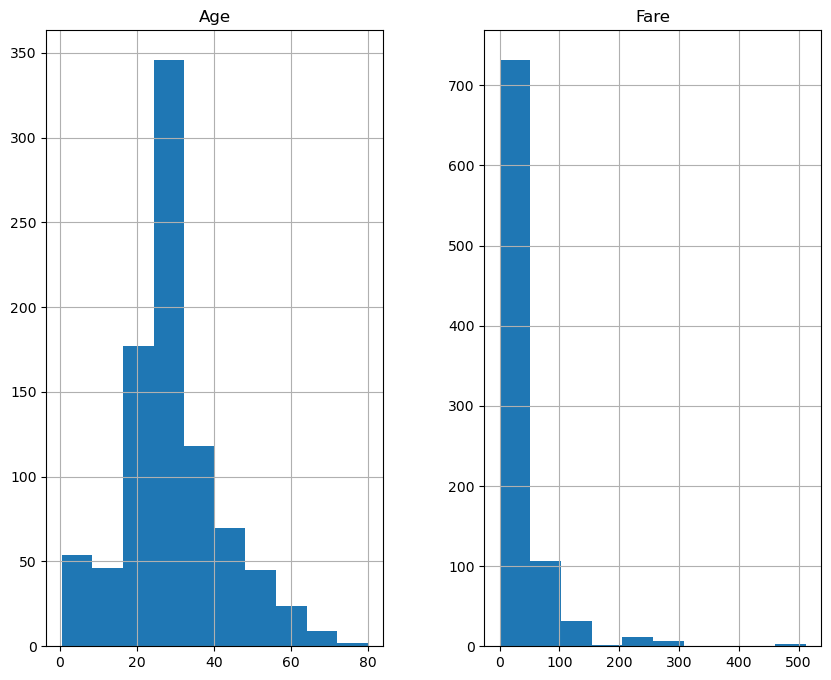

In [56]:
# Check their formats
X_train[numerical_cols].hist(figsize=(10, 8))
plt.show()

Applying log transformation to Fare, Parch and SibSp to reduce skewness

In [57]:
X_train['Fare'] = np.log1p(X_train['Fare'])

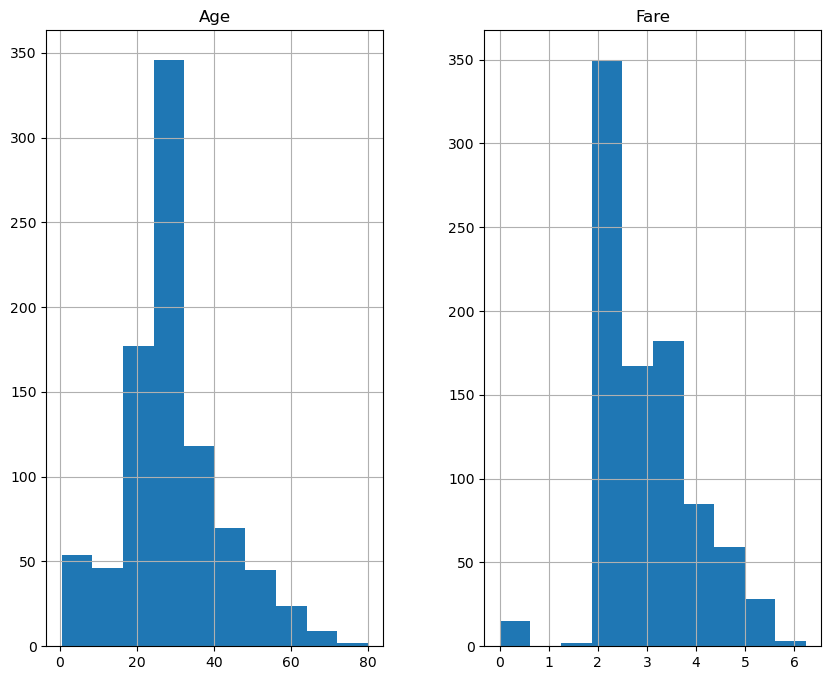

In [58]:
# Check their formats
X_train[numerical_cols].hist(figsize=(10, 8))
plt.show()

### Standardizing the data

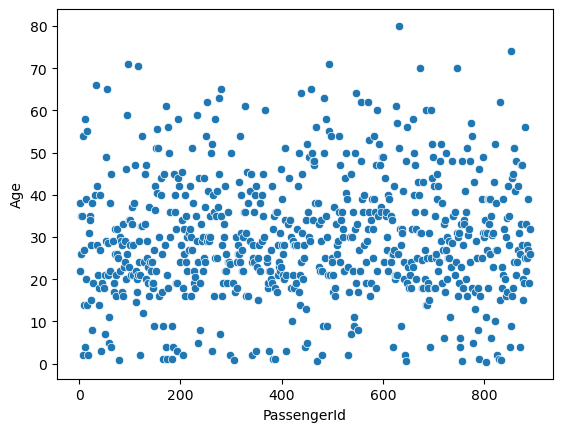

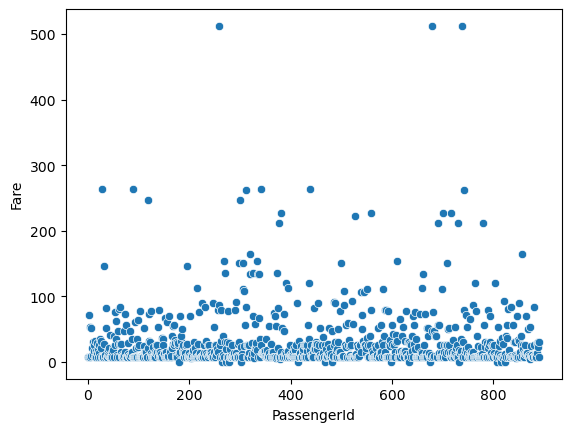

In [59]:
sns.scatterplot(data=df_train, x='PassengerId', y='Age')
plt.show()
sns.scatterplot(data=df_train, x='PassengerId', y='Fare')
plt.show()

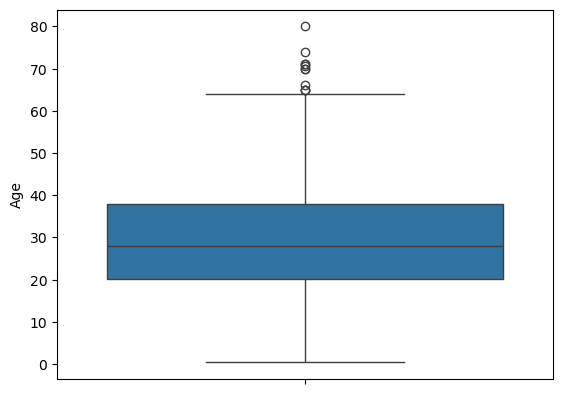

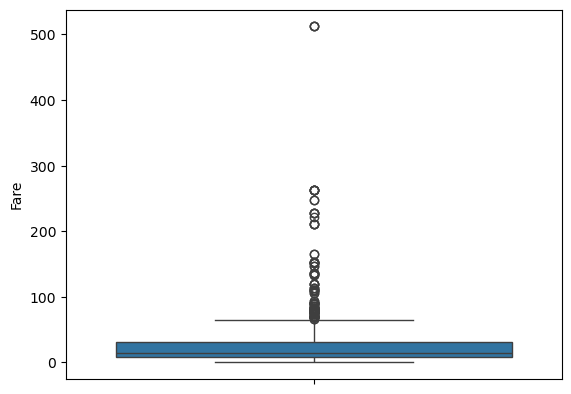

In [60]:
sns.boxplot(data=df_train, y='Age')
plt.show()
sns.boxplot(data=df_train, y='Fare')
plt.show()

In [61]:
# from sklearn.preprocessing import StandardScaler

# # Create an instance of the StandardScaler
# scaler = StandardScaler()

# # Apply standard scaling to the numerical features
# X_train[numerical_features] = pd.DataFrame(scaler.fit_transform(X_train[numerical_features]),columns=numerical_features)
# # X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
# X_train[numerical_features].head()

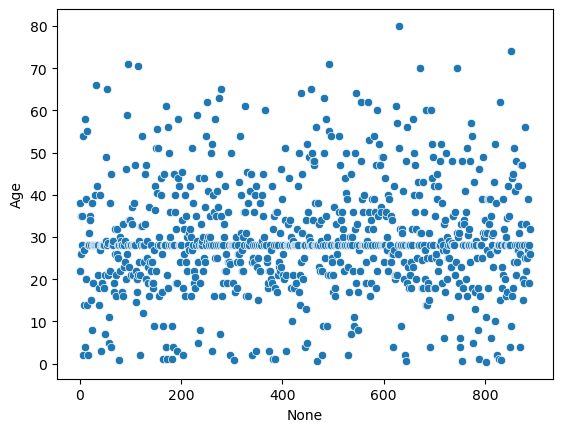

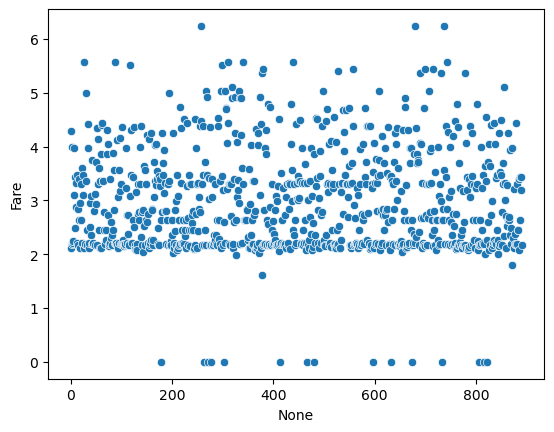

In [62]:
sns.scatterplot(data=X_train, x=X_train.index, y='Age')
plt.show()
sns.scatterplot(data=X_train, x=X_train.index, y='Fare')
plt.show()

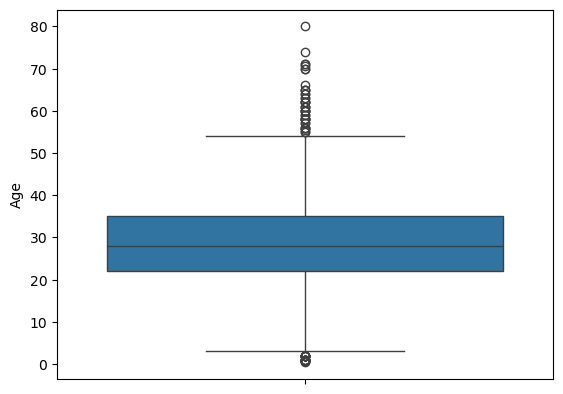

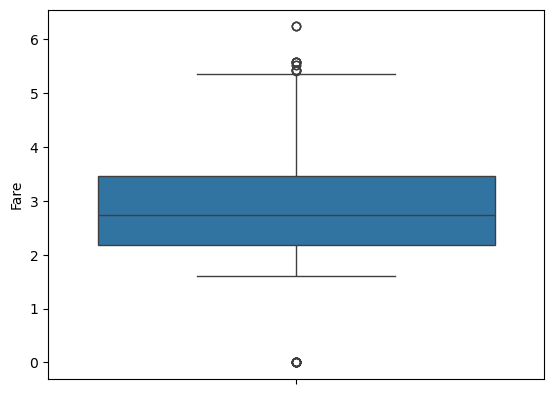

In [63]:
sns.boxplot(data=X_train, y='Age')
plt.show()
sns.boxplot(data=X_train, y='Fare')
plt.show()

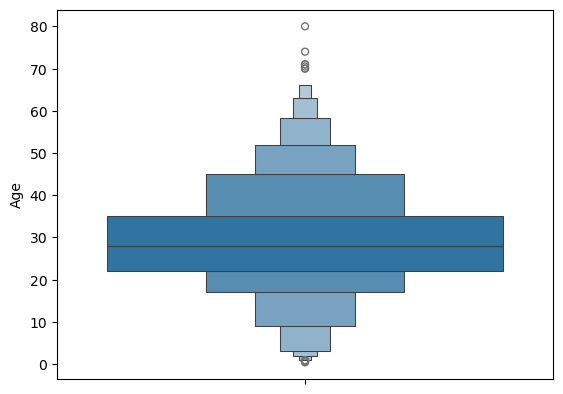

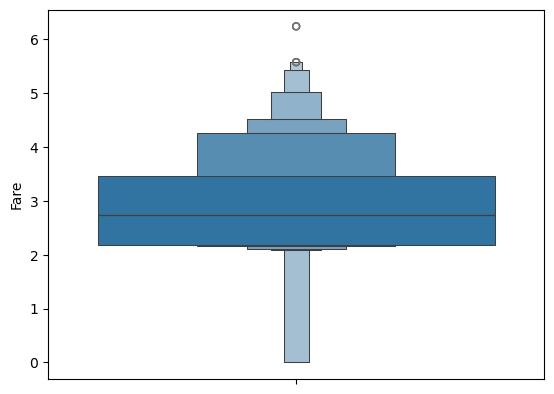

In [64]:
# Letter-value plots
sns.boxenplot(data=X_train, y='Age')
plt.show()
sns.boxenplot(data=X_train, y='Fare')
plt.show()

In [ ]:
# from ydata_profiling import ProfileReport
# report = ProfileReport(df_train, title="Pandas Profiling Report")
# report

# Model Building with XGBoost

In [65]:
import xgboost as xgb
xgb_model=xgb.XGBClassifier()

## Hyperparameter tunning with Randomized Search

In [66]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameters to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_model, param_distributions=param_grid, n_iter=100, scoring='accuracy', n_jobs=-1, cv=5, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Evaluate results
best_params = random_search.best_params_
best_score = random_search.best_score_
model = random_search.best_estimator_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}
Best Score: 0.8451572406000878


In [67]:
# Fit the best model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred_test = model.predict(X_test)

In [73]:
ds_submission = df_test[['PassengerId']].copy()
ds_submission['Survived'] = y_pred_test
ds_submission.to_csv('submission.csv', index=False)